In [18]:
import numpy as np
import pandas as pd
import gym
from gym import spaces

In [19]:
ped_df = pd.read_csv("PED_Results.csv")

In [20]:
# Define a Custom Gym Environment
class PricingEnv(gym.Env):
    def __init__(self, ped_df):
        super(PricingEnv, self).__init__()
        
        self.ped_df = ped_df
        self.current_index = 0
        
        # Store original prices for comparison
        self.ped_df["Initial_Price"] = self.ped_df["Item_MRP"]
        self.ped_df["New_Price"] = self.ped_df["Item_MRP"]  # Placeholder for RL-updated price

        # Define State and Action Space
        self.observation_space = spaces.Box(low=np.array([0, -10]), high=np.array([500, 10]), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 0: Decrease, 1: Maintain, 2: Increase

    def reset(self):
        self.current_index = np.random.randint(0, len(self.ped_df))  
        self.state = np.array([self.ped_df.iloc[self.current_index]["Item_MRP"], 
                               self.ped_df.iloc[self.current_index]["PED"]])
        return self.state

    def step(self, action):
        current_price, ped = self.state
        
        if action == 0:  
            new_price = current_price * 0.95  
        elif action == 1:  
            new_price = current_price
        else:  
            new_price = current_price * 1.05  

        demand_change = ped * ((new_price - current_price) / current_price) * 100  
        revenue = new_price * (100 + demand_change) / 100  

        reward = revenue  

        # Update the price in the dataframe for tracking
        self.ped_df.loc[self.current_index, "New_Price"] = new_price

        self.state = np.array([new_price, ped])
        done = False  

        return self.state, reward, done, {}


In [21]:
# Initialize Environment
env = PricingEnv(ped_df)

# Q-Learning Parameters
q_table = np.zeros((500, 21, 3))  
learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.99
min_exploration = 0.01
episodes = 1000


c:\Users\jasra\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [15]:
# Training Q-Learning
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    for _ in range(100):
        if np.random.rand() < exploration_rate:
            action = env.action_space.sample()  
        else:
            action = np.argmax(q_table[int(state[0]), int(state[1])]) 
        
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        q_table[int(state[0]), int(state[1]), action] = (1 - learning_rate) * q_table[int(state[0]), int(state[1]), action] + \
            learning_rate * (reward + discount_factor * np.max(q_table[int(next_state[0]), int(next_state[1])]))
        
        state = next_state

        if done:
            break

    exploration_rate = max(min_exploration, exploration_rate * exploration_decay)


In [22]:
# Training Q-Learning
for episode in range(episodes):
    state = env.reset()
    for _ in range(100):
        if np.random.rand() < exploration_rate:
            action = env.action_space.sample()  
        else:
            action = np.argmax(q_table[int(state[0]), int(state[1])]) 
        
        next_state, reward, done, _ = env.step(action)
        
        q_table[int(state[0]), int(state[1]), action] = (1 - learning_rate) * q_table[int(state[0]), int(state[1]), action] + \
            learning_rate * (reward + discount_factor * np.max(q_table[int(next_state[0]), int(next_state[1])]))
        
        state = next_state

        if done:
            break

    exploration_rate = max(min_exploration, exploration_rate * exploration_decay)

In [23]:
# Save Trained Model
np.save("q_table.npy", q_table)
print("Q-Learning Training Completed! Q-Table saved.")

# **Compare Initial vs New Prices**
print("\n📊 Comparing Old Prices vs. New Prices")
comparison_df = env.ped_df[["Item_Type", "Initial_Price", "New_Price"]]
comparison_df["Price_Change (%)"] = ((comparison_df["New_Price"] - comparison_df["Initial_Price"]) / comparison_df["Initial_Price"]) * 100

print(comparison_df.head(10))  # Show first 10 items


Q-Learning Training Completed! Q-Table saved.

📊 Comparing Old Prices vs. New Prices
               Item_Type  Initial_Price   New_Price  Price_Change (%)
0                 Breads     140.952669  154.624287          9.699439
1              Breakfast     141.788151  126.688959        -10.649121
2                 Canned     139.763832  131.782311         -5.710720
3                  Dairy     148.499208  148.499208          0.000000
4           Frozen Foods     138.503366  160.334959         15.762500
5  Fruits and Vegetables     144.581235  154.683995          6.987601
6            Hard Drinks     137.077928  154.762049         12.900780
7     Health and Hygiene     130.818921  154.692660         18.249454
8              Household     149.424753  156.895991          5.000000
9                   Meat     139.882032  132.887931         -5.000000


C:\Users\jasra\AppData\Local\Temp\ipykernel_23752\3192202817.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df["Price_Change (%)"] = ((comparison_df["New_Price"] - comparison_df["Initial_Price"]) / comparison_df["Initial_Price"]) * 100


C:\Users\jasra\AppData\Local\Temp\ipykernel_23752\4272980482.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Item_Type", y="Price_Change (%)", data=comparison_df, palette="coolwarm")


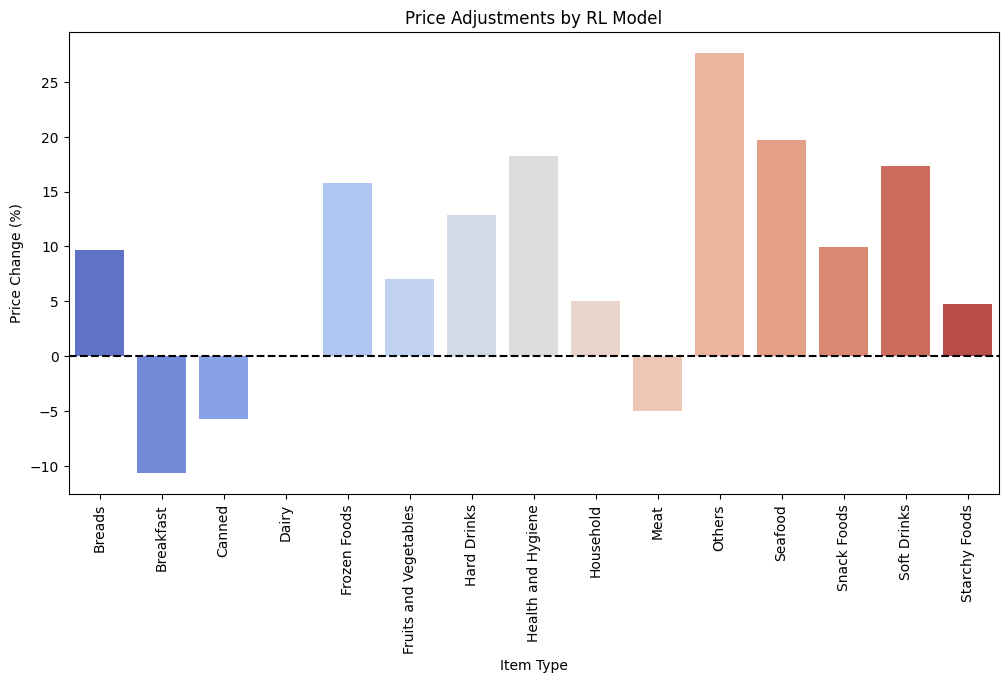

In [24]:
# **Save Comparison Results**
comparison_df.to_csv("RL_Pricing_Comparison.csv", index=False)

# **Visualizing Price Changes**
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="Item_Type", y="Price_Change (%)", data=comparison_df, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Price Adjustments by RL Model")
plt.axhline(0, color='black', linestyle="--")  # Baseline for no change
plt.xlabel("Item Type")
plt.ylabel("Price Change (%)")
plt.show()